In [1]:
import pipeline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import time
import PIL.Image

from datetime import timedelta
from IPython.display import display
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

Using TensorFlow backend.


In [2]:
directory = '/home/ubuntu/OG/'
num_species = 14
image_resize = 155

train_labels = pipeline.make_image_label_pickle(directory, num_species, nwidth=image_resize, nheight=image_resize)

Time to pickle: 0:02:43


In [3]:
num_species

14

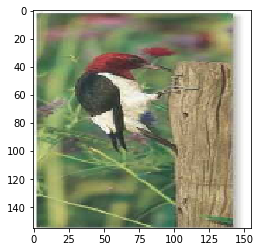

In [4]:
train = pickle.load(open("images.p", "rb"))
plt.imshow(train[1,:,:,:])

In [5]:
train[1,:,:,:]

array([[[0.99607843, 0.99607843, 0.96470588],
        [0.99215686, 0.99215686, 0.96078431],
        [1.        , 0.99607843, 0.97647059],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 0.98039216],
        [0.99607843, 1.        , 0.97647059],
        [1.        , 1.        , 0.98039216],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.99607843, 1.        , 1.        ],
        [0.98431373, 0.99215686, 0.98039216],
        [0.77254902, 0.78431373, 0.74901961],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.99215686, 0.99215686, 0.96078431],
        [0.97647059, 0.98039216, 0.94901961],
        [0.62745098, 0

In [6]:
num_validation = 0.10
X_train, X_validation, y_train, y_validation = train_test_split(train, train_labels, test_size=num_validation, random_state=6)

onehot_encoder = OneHotEncoder(sparse=False, categories='auto') # Creates a code/cypher for what species the
y_train_temp = y_train.reshape(len(y_train), 1)                 # bird is as a list of 1s and 0s
y_train = onehot_encoder.fit_transform(y_train_temp)

y_validation_temp = y_validation.reshape(len(y_validation), 1)
y_validation = onehot_encoder.fit_transform(y_validation_temp)
print(y_validation[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [7]:
img_shape = (image_resize, image_resize, 3)
# Load the unedited model
base_model = tf.keras.applications.Xception(
    input_shape=img_shape,
    include_top=False)

W0816 15:13:45.773884 140159638067008 deprecation.py:506] From /home/ubuntu/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# Freeze the pre-trained model weights
base_model.trainable = False
# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D(input_shape=base_model.output_shape[1:])
prediction_layer = tf.keras.layers.Dense(14, activation='softmax')
dropout = tf.keras.layers.Dropout(0.2)
dense512 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))
dense256 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))
# Layer classification head with feature detector
model = tf.keras.Sequential([base_model,
                             maxpool_layer,
                             dense512,
                             dropout,
                             dense256,
                             dropout,
                             prediction_layer])
learning_rate = 0.0001
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
print("Going birdwatching...")
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
model.fit(X_train, y_train, epochs=50, validation_data=(X_validation, y_validation),
          batch_size=20, callbacks=[checkpointer])

Going birdwatching...
Train on 6165 samples, validate on 686 samples
Epoch 1/50
6160/6165 [============================>.] - ETA: 0s - loss: 12.5793 - acc: 0.1636
Epoch 00001: val_loss improved from inf to 10.82525, saving model to weights.hdf5
6165/6165 [==============================] - 220s 36ms/sample - loss: 12.5780 - acc: 0.1635 - val_loss: 10.8253 - val_acc: 0.3280
Epoch 2/50
6160/6165 [============================>.] - ETA: 0s - loss: 9.6918 - acc: 0.2628
Epoch 00002: val_loss improved from 10.82525 to 8.57171, saving model to weights.hdf5
6165/6165 [==============================] - 219s 35ms/sample - loss: 9.6907 - acc: 0.2628 - val_loss: 8.5717 - val_acc: 0.3644
Epoch 3/50
6160/6165 [============================>.] - ETA: 0s - loss: 7.7625 - acc: 0.3180
Epoch 00003: val_loss improved from 8.57171 to 7.06683, saving model to weights.hdf5
6165/6165 [==============================] - 218s 35ms/sample - loss: 7.7620 - acc: 0.3179 - val_loss: 7.0668 - val_acc: 0.3834
Epoch 4/50
6

Epoch 28/50
6160/6165 [============================>.] - ETA: 0s - loss: 2.2321 - acc: 0.4604
Epoch 00028: val_loss did not improve from 2.64194
6165/6165 [==============================] - 217s 35ms/sample - loss: 2.2324 - acc: 0.4602 - val_loss: 2.6488 - val_acc: 0.4067
Epoch 29/50
6160/6165 [============================>.] - ETA: 0s - loss: 2.2144 - acc: 0.4643
Epoch 00029: val_loss did not improve from 2.64194
6165/6165 [==============================] - 216s 35ms/sample - loss: 2.2140 - acc: 0.4644 - val_loss: 2.6814 - val_acc: 0.4067
Epoch 30/50
6160/6165 [============================>.] - ETA: 0s - loss: 2.1984 - acc: 0.4534
Epoch 00030: val_loss did not improve from 2.64194
6165/6165 [==============================] - 216s 35ms/sample - loss: 2.1985 - acc: 0.4534 - val_loss: 2.6757 - val_acc: 0.3921
Epoch 31/50
6160/6165 [============================>.] - ETA: 0s - loss: 2.1938 - acc: 0.4599
Epoch 00031: val_loss did not improve from 2.64194
6165/6165 [=========================

In [10]:
model.save("model.h5") # Save our newly trained model
model.save("model_backup.h5")
print("Saved model to EC2")

Saved model to EC2
